In [114]:
import os

from datetime import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import json

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

from mpl_toolkits.axes_grid1 import host_subplot
from tqdm import tqdm

from src.data_processing import get_splitted_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Configure SageMaker environment

In [115]:
# set SageMaker role
os.environ['AWS_PROFILE']='sagemaker'
os.environ['AWS_DEFAULT_REGION']='eu-central-1'

In [116]:
session = sagemaker.Session()
bucket = session.default_bucket()
print(bucket)
prefix = "sagemaker/ml-capistone-project"
role = sagemaker.get_execution_role()

sagemaker-eu-central-1-292065287762


## Prepare data

In [117]:
# Load data
stock_list = ['NFLX', 'EPAM', 'AAPL']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

stock_data = [NFLX, EPAM, AAPL]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [118]:
# set data
stock_df = EPAM
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-06,99.669998,100.279999,98.040001,99.949997,99.949997,332800
2017-11-07,99.949997,101.550003,98.839996,100.730003,100.730003,465800
2017-11-08,100.419998,103.440002,100.160004,102.989998,102.989998,349800
2017-11-09,102.019997,103.250000,101.529999,102.339996,102.339996,233100
2017-11-10,101.779999,103.489998,101.720001,102.800003,102.800003,163200


In [119]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-11-06 to 2022-11-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [120]:
# save data
data_folder='data'
os.makedirs(data_folder, exist_ok=True)  
stock_df.to_csv(data_folder + '/stock.csv') 

In [121]:
# upload stock data to S3
inputs = session.upload_data(path=data_folder, bucket=bucket, key_prefix=prefix)
print("S3 path: {}".format(inputs))

S3 path: s3://sagemaker-eu-central-1-292065287762/sagemaker/ml-capistone-project


## Hyperparameter tunner

### Find best CPU otimized instance for training

In [122]:
spot_use_instances = True
spot_max_wait=2500
spot_max_run=2500
hyperparameters = {
    'epochs': 600,
    'learning_rate': 0.0001,
    'feature_columns': '"Adj Close"' # for multiple values use: '"Adj Close" "Volume"'
}

In [128]:
# Optimal instances for current paylad.
# CPU instantce ml.c5.2xlarge
# GPU instance ml.g4dn.xlarge -> best instance
estimator = PyTorch(
    entry_point='hpo.py',
    source_dir='src',
    base_job_name='stock-predictor',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.2xlarge',
    framework_version='1.12',
    py_version='py38',
    hyperparameters=hyperparameters,
    # use_spot_instances=spot_use_instances,
    # max_wait=spot_max_wait,
    # max_run=spot_max_run
)

In [129]:
estimator.fit({'data': inputs}, wait=True)

2022-11-07 11:18:56 Starting - Starting the training job...
2022-11-07 11:19:19 Starting - Preparing the instances for trainingProfilerReport-1667819935: InProgress
.........
2022-11-07 11:21:00 Downloading - Downloading input data
2022-11-07 11:21:00 Training - Downloading the training image.................................
2022-11-07 11:26:41 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-07 11:26:32,044 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-07 11:26:32,071 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-07 11:26:32,078 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-07 11:26:32,511 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip instal

### Find best hyperparameters

In [130]:
spot_use_instances = True
spot_max_wait=2500
spot_max_run=2500
hyperparameters = {
    'epochs': 600,
    'feature_columns': '"Adj Close"', # for multiple values use: '"Adj Close" "Volume"'
    'use_mask': True,
    'learning_rate': 0.0001
}

In [137]:
estimator = PyTorch(
    entry_point='hpo.py',
    source_dir='src',
    base_job_name='stock-predictor',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.12',
    py_version='py38',
    hyperparameters=hyperparameters,
    # use_spot_instances=spot_use_instances,
    # max_wait=spot_max_wait,
    # max_run=spot_max_run
)

In [138]:
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Train loss: ([0-9\\.]+)"}]

In [139]:
# 0.0001 is best descovered learning rate
# use_mask = False perform better
hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.00005, 0.005),
    'use_mask': CategoricalParameter([True, False])
}

In [140]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=12,
    max_parallel_jobs=3,
    objective_type=objective_type
)

In [141]:
tuner.fit({'data': inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [144]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

# Tunning results
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-221107-2256')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,learning_rate,use_mask,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
3,0.003787,"""False""",pytorch-training-221107-2256-009-5b091a3b,Completed,0.089791,2022-11-07 23:19:16+01:00,2022-11-07 23:27:19+01:00,483.0
0,0.000876,"""True""",pytorch-training-221107-2256-012-9b75ae38,Completed,0.005049,2022-11-07 23:27:50+01:00,2022-11-07 23:35:55+01:00,485.0
5,0.000110,"""False""",pytorch-training-221107-2256-007-638843a2,Completed,0.005005,2022-11-07 23:19:12+01:00,2022-11-07 23:26:46+01:00,454.0
6,0.000098,"""False""",pytorch-training-221107-2256-006-faf767ad,Completed,0.003014,2022-11-07 23:10:43+01:00,2022-11-07 23:18:46+01:00,483.0
1,0.000056,"""True""",pytorch-training-221107-2256-011-eeb5fdad,Completed,0.002783,2022-11-07 23:27:48+01:00,2022-11-07 23:35:47+01:00,479.0
2,0.000050,"""True""",pytorch-training-221107-2256-010-0dee42de,Completed,0.002684,2022-11-07 23:27:46+01:00,2022-11-07 23:35:20+01:00,454.0
10,0.000176,"""True""",pytorch-training-221107-2256-002-008648f0,Completed,0.002536,2022-11-07 22:57:24+01:00,2022-11-07 23:10:08+01:00,764.0
4,0.000110,"""False""",pytorch-training-221107-2256-008-367504cd,Completed,0.002517,2022-11-07 23:19:13+01:00,2022-11-07 23:27:11+01:00,478.0
9,0.000074,"""True""",pytorch-training-221107-2256-003-7a645f34,Completed,0.002185,2022-11-07 22:57:34+01:00,2022-11-07 23:09:49+01:00,735.0
7,0.000219,"""False""",pytorch-training-221107-2256-005-e96fa1c7,Completed,0.001848,2022-11-07 23:10:44+01:00,2022-11-07 23:18:42+01:00,478.0


In [146]:
best_estimator=tuner.best_estimator()
best_estimator.hyperparameters()


2022-11-07 22:19:09 Starting - Found matching resource for reuse
2022-11-07 22:19:09 Downloading - Downloading input data
2022-11-07 22:19:09 Training - Training image download completed. Training in progress.
2022-11-07 22:19:09 Uploading - Uploading generated training model
2022-11-07 22:19:09 Completed - Resource reused by training job: pytorch-training-221107-2256-007-638843a2


{'_tuning_objective_metric': '"Test Loss"',
 'epochs': '600',
 'feature_columns': '"\\"Adj Close\\""',
 'learning_rate': '0.00010899212696203938',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"stock-predictor-2022-11-07-21-55-57-206"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"eu-central-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-07-21-55-57-206/source/sourcedir.tar.gz"',
 'use_mask': '"False"'}

## Stock estimator

In [348]:
# best training job parameters
# default learning rate: 0.0001
learning_rate = 0.000109	 # 0.0000634
use_mask = False # True

In [349]:
# estimator configuration
instance_type = 'ml.g4dn.xlarge' # default 'ml.g4dn.xlarge'
spot_use_instances = True
spot_max_wait=10000
spot_max_run=10000

In [350]:
hyperparameters = {
    'epochs': 2000,
    'learning_rate': learning_rate,
    'use_mask': True,
    'feature_columns': '"Adj Close"' # for multiple values use: '"Adj Close" "Volume"'
}
hyperparameters

{'epochs': 2000,
 'learning_rate': 0.000109,
 'use_mask': True,
 'feature_columns': '"Adj Close"'}

In [351]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [352]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [353]:
estimator = PyTorch(
    entry_point='hpo.py',
    source_dir='src',
    base_job_name='stock-predictor',
    role=role,
    instance_count=1,
    instance_type=instance_type,
    framework_version='1.12',
    py_version='py38',
    hyperparameters=hyperparameters,
    ## Spot instances
    use_spot_instances=spot_use_instances,
    max_wait=spot_max_wait,
    max_run=spot_max_run,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [354]:
estimator.fit({'data': inputs}, wait=True)

2022-11-10 12:49:04 Starting - Starting the training job...
2022-11-10 12:49:32 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-11-10 12:50:33 Downloading - Downloading input data
2022-11-10 12:50:33 Training - Downloading the training image................................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-10 12:55:53,517 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-10 12:55:53,546 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-10 12:55:53,553 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-10 12:55:54,150 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": 

In [355]:
model=estimator.model_data
model

's3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-10-12-49-01-977/output/model.tar.gz'

In [356]:
training_job_name = estimator.latest_training_job.name
print(f"Training job name: {training_job_name}")

Training job name: stock-predictor-2022-11-10-12-49-01-977


In [357]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-11-10 15:05:54.463 MacBook-Pro-2.local:55875 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-10-12-49-01-977/debug-output
[2022-11-10 15:06:10.469 MacBook-Pro-2.local:67923 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-10 15:06:10.469 MacBook-Pro-2.local:67920 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-10 15:06:10.512 MacBook-Pro-2.local:67926 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-10 15:06:10.518 MacBook-Pro-2.local:67929 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-10 15:06:10.537 MacBook-Pro-2.local:67928 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-10 15:06:10.541 MacBook-Pro-2.local:67921 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-10 15:06:10.556 MacBook-Pro-2.local:67930 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-10 15:06:10.560 MacBook-Pro-2.local:67927 INFO utils.py

In [358]:
trial.tensor_names()

['MSELoss_output_0',
 'gradient/TransformerTime2Vec_decoder.bias',
 'gradient/TransformerTime2Vec_decoder.weight',
 'gradient/TransformerTime2Vec_embedding.bias',
 'gradient/TransformerTime2Vec_embedding.weight',
 'gradient/TransformerTime2Vec_time2vecEncoder.bias_linear',
 'gradient/TransformerTime2Vec_time2vecEncoder.bias_periodic',
 'gradient/TransformerTime2Vec_time2vecEncoder.weights_linear',
 'gradient/TransformerTime2Vec_time2vecEncoder.weights_periodic',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.linear1.bias',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.linear1.weight',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.linear2.bias',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.linear2.weight',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.norm1.bias',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.norm1.weight',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.norm2.bias',
 'gradie

In [359]:
print(len(trial.tensor("MSELoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("MSELoss_output_0").steps(mode=ModeKeys.EVAL)))
print(len(trial.tensor("MSELoss_output_0").steps(mode=ModeKeys.PREDICT)))

33033
4004
0


In [360]:
def get_data(trial, tname, mode, sampling=500):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)[::sampling]
    vals = []
    for s in tqdm(steps):
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [361]:
def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

100%|██████████| 67/67 [12:06<00:00, 10.84s/it]


loaded TRAIN data


100%|██████████| 9/9 [01:25<00:00,  9.52s/it]


loaded EVAL data
completed TRAIN plot
completed EVAL plot


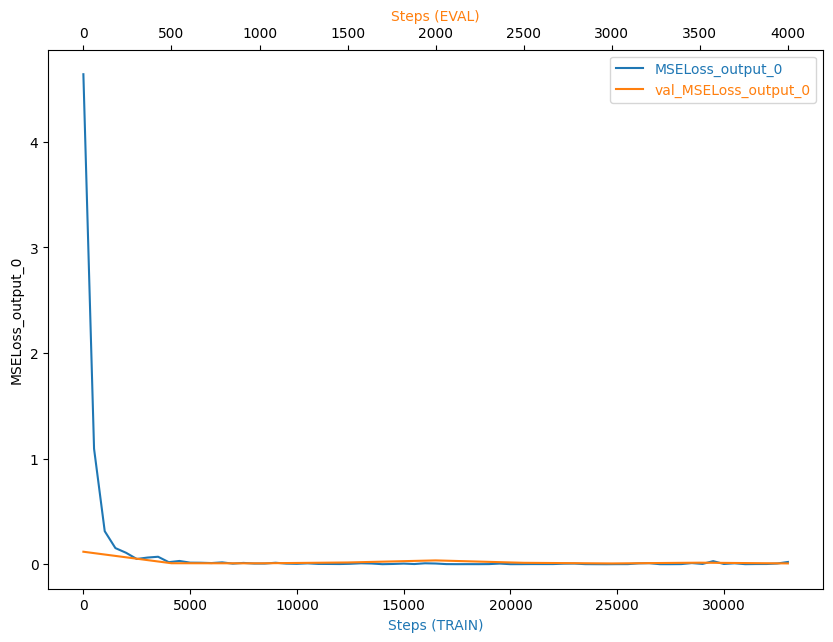

In [362]:
plot_tensor(trial, "MSELoss_output_0")

In [363]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
region = session.boto_region_name
training_job = TrainingJob(training_job_name, region)
training_job.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-eu-central-1-292065287762/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-10-12-49-01-977/profiler-output


Profiler data from system is available


In [364]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = training_job.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-11-10 16:25:29.073 MacBook-Pro-2.local:55875 INFO metrics_reader_base.py:134] Getting 27 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


In [366]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-10-12-49-01-977/rule-output


In [367]:
! aws s3 ls {rule_output_path} --recursive

2022-11-10 14:17:01     407191 stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-11-10 14:17:00     270101 stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-11-10 14:16:55        589 stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-11-10 14:16:55       7299 stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-11-10 14:16:55       2424 stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-11-10 14:16:55        130 stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-11-10 14:16:55       8780 stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-reports/I

In [368]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-10-12-49-01-977/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-eu-central-1-292065287762/sto

In [369]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [370]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [371]:
from sagemaker.serverless import ServerlessInferenceConfig

serverless_config = ServerlessInferenceConfig(
	memory_size_in_mb=6144, # max amount of memory
	max_concurrency=1
)
endpoint_name = "stock-predictor-serverless"

In [ ]:
# # deploy model from source
# model = estimator.create_model(entry_point="hpo.py", source_dir="src")

# # Deploy the model to a ml.m4.xlarge instance
# predictor = model.deploy(
#     serverless_inference_config=serverless_config
# )

In [ ]:
# inputs = [546, 578, 590]
# predicted_classes = predictor.predict(inputs)
# print(predicted_classes)

In [ ]:
# # deploy estimator from training job
# attached_estimator = Estimator.attach(training_job_name)
# attached_estimator.logs()
# attached_estimator.deploy(
#   endpoint_name = endpoint_name, 
# 	entry_point="hpo.py",
# 	serverless_inference_config=serverless_config
# )

In [ ]:
# estimator.logs()
# predictor_server = estimator.deploy(
# 	endpoint_name = "stock-predictor-serverless-server", 
# 	entry_point="inference.py", # default "hpo.py"
# 	instance_type=instance_type,
#     initial_instance_count=1
# )

In [ ]:
# stock_input = [[[10], [24], [56], [55], [23], [45], [77]]]
# predicted_classes = predictor_server.predict(stock_input)
# print(predicted_classes)

In [372]:
# serverless config
estimator.logs()
predictor = estimator.deploy(
	endpoint_name = endpoint_name, 
	entry_point="inference.py",
	serverless_inference_config=serverless_config
)

2022-11-10 13:17:11 Starting - Preparing the instances for training
2022-11-10 13:17:11 Downloading - Downloading input data
2022-11-10 13:17:11 Training - Training image download completed. Training in progress.
2022-11-10 13:17:11 Uploading - Uploading generated training model
2022-11-10 13:17:11 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-10 12:55:53,517 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-10 12:55:53,546 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-10 12:55:53,553 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-10 12:55:54,150 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "data": "/opt/ml/input/data/data"
    },
    "cur

In [373]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=JSONLinesSerializer(),
    deserializer=JSONLinesDeserializer(),
    sagemaker_session=session
)

stock_input = "[[[100], [240], [59], [55], [230], [450], [770]]]"
predicted_classes = predictor.predict(stock_input)
print(predicted_classes)

[[[204.3155465579648]]]


In [374]:
# take test data from stock dataset
valid_len = 105 # in days
test_len = 105 # in days
target_len = 1
seq_len = 7 + target_len

train, valid, test = get_splitted_data(EPAM, valid_days=valid_len, test_days=test_len)

# original value
original = np.array([])
# predictions, entire interval prediction based on previously predicted data
predictions = np.array([])

# generate predicted data
for i in range(seq_len, len(test) + 1):
    x_seq = test['Adj Close'][i-seq_len:i-target_len]
    y_seq = test['Adj Close'][i-target_len:i]
    x = np.array(x_seq)
    x = np.expand_dims(x, axis=1)
    x = np.expand_dims(x, axis=0)
    y = np.array(y_seq)
    original = np.append(original, y.squeeze())
    # x = np.expand_dims(x, axis=1)
    x_json = json.dumps(x.tolist())
    predicted_price = predictor.predict(x_json)
    predictions = np.append(predictions, np.array(predicted_price).squeeze())

Split data into train/validation/test datasets
Valid days: 105, test days: 105
Train data shape: (1049, 6)
Valid data shape: (105, 6)
Test data shape: (105, 6)


<AxesSubplot: >

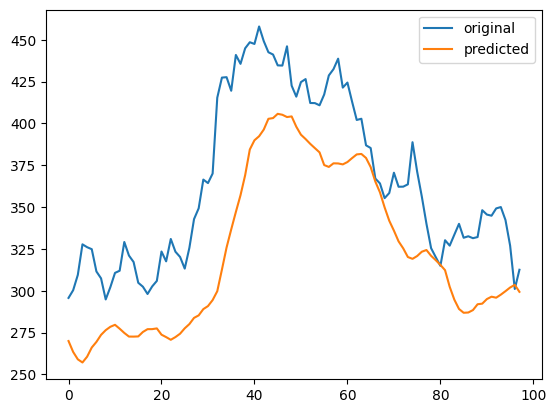

In [375]:
data = {'original': original, 'predicted': predictions}
result = pd.DataFrame(data=data)
result.plot()

In [376]:
# several days prediction
# number of days to predict
days = 7
# original value
original = np.array([])
# predictions, entire interval prediction based on previously predicted data
predictions = None

# generate predicted data
for i in range(seq_len, len(test) + 1):
    x_seq = test['Adj Close'][i-seq_len:i-target_len]
    y_seq = test['Adj Close'][i-target_len:i]
    x = np.array(x_seq)
    y = np.array(y_seq)
    original = np.append(original, y.squeeze())
    days_predictions = np.array([])
    for day_index in range(days):
        x = np.expand_dims(x, axis=1)
        x = np.expand_dims(x, axis=0)
        x_json = json.dumps(x.tolist())
        predicted_price = predictor.predict(x_json)
        days_predictions = np.append(days_predictions, np.array(predicted_price).squeeze())
        # adjust x
        x = np.append(x, np.array(predicted_price).squeeze())[1:]

    if predictions is None:
        predictions = days_predictions
    else:
        predictions = np.vstack((predictions, days_predictions))
    

<AxesSubplot: >

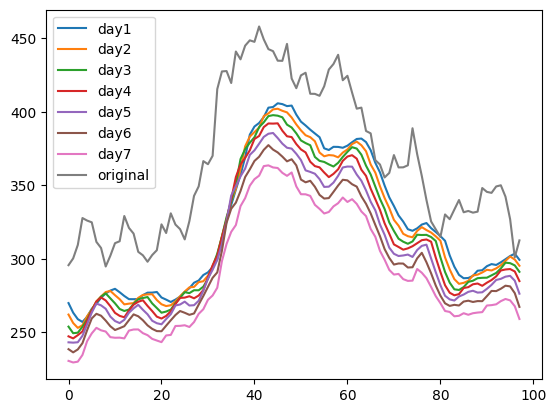

In [377]:
result = pd.DataFrame(predictions, columns=['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7'])
result['original'] = original
result.plot()

<AxesSubplot: >

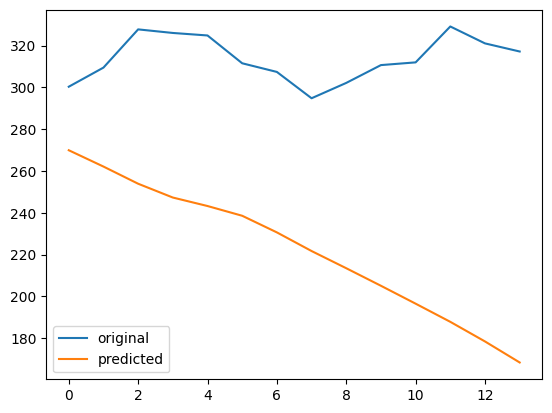

In [386]:
# made prediction for 2 weeks in advance
days = 14
# predictions, entire interval prediction based on previously predicted data
start_sequence = test['Adj Close'][0:i-target_len]
predictions = np.array([])

# generate predicted data
x_seq = test['Adj Close'][0:7]
y_seq = test['Adj Close'][seq_len:seq_len + days]
original = np.array(y_seq)
x = np.array(x_seq)

for day_index in range(days):
    x = np.expand_dims(x, axis=1)
    x = np.expand_dims(x, axis=0)
    x_json = json.dumps(x.tolist())
    predicted_price = predictor.predict(x_json)
    predictions = np.append(predictions, np.array(predicted_price).squeeze())
    x = np.append(x, np.array(predicted_price).squeeze())[1:]

data = {'original': original, 'predicted': predictions}
result = pd.DataFrame(data=data)
result.plot()

In [347]:
predictor.delete_endpoint()

In [387]:
# try to deploy endpoint from the yesterday model
from sagemaker.pytorch.model import PyTorchModel

bucket = 's3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-09-22-41-29-524/model.tar.gz'
pytorch_model = PyTorchModel(
    model_data=bucket,
    role=role,
    source_dir='src',
    entry_point="inference.py",
    framework_version="1.12",
    py_version="py38"
)

In [388]:
model_predictor = pytorch_model.deploy(
    initial_instance_count=1,
    serverless_inference_config=serverless_config,
    serializer=JSONLinesSerializer(),
    deserializer=JSONLinesDeserializer(),
)

------!

In [389]:
stock_input = "[[[100], [240], [59], [55], [230], [450], [770]]]"
predicted_classes = model_predictor.predict(stock_input)
print(predicted_classes)

[[[304.82843635560766]]]


<AxesSubplot: >

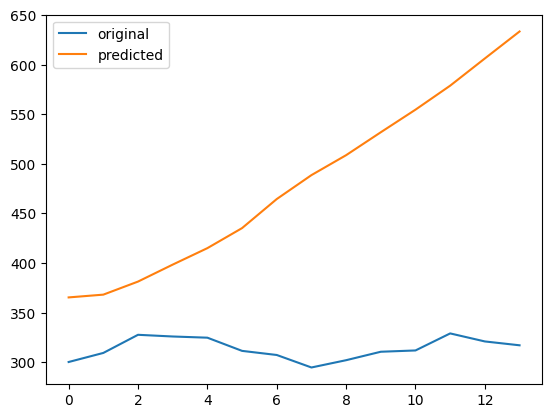

In [392]:
# made prediction for 2 weeks in advance
days = 14
# predictions, entire interval prediction based on previously predicted data
start_sequence = test['Adj Close'][0:i-target_len]
predictions = np.array([])

# generate predicted data
x_seq = test['Adj Close'][0:7]
y_seq = test['Adj Close'][seq_len:seq_len + days]
original = np.array(y_seq)
x = np.array(x_seq)

for day_index in range(days):
    x = np.expand_dims(x, axis=1)
    x = np.expand_dims(x, axis=0)
    x_json = json.dumps(x.tolist())
    predicted_price = model_predictor.predict(x_json)
    predictions = np.append(predictions, np.array(predicted_price).squeeze())
    x = np.append(x, np.array(predicted_price).squeeze())[1:]

data = {'original': original, 'predicted': predictions}
result = pd.DataFrame(data=data)
result.plot()